In [13]:
import json 
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
from utils1 import openJson,saveJson

## Filtering 1

- videosF1.json contain the videos with fr-FR on the language parameter

In [ ]:
videosR3 = openJson("../jsons/videosR3.json")
len(videosR3)

In [ ]:
videosF1 = []
for video in videosR3:
    if video['langue']== 'fr-FR':
        videosF1.append(video)
saveJson("../jsons/videosF1.json",videosF1)
len(videosF1)

In [ ]:
videosF1 = openJson("../jsons/videosF1.json")
len(videosF1)

## Filtering 2

### Detecter les videos des Chaines TV 

In [ ]:
chainesTv = [
    "France 2", "France 3", "France 4","France 5","Franceinfo",
    "BFMTV", "C8", "CStar", "Gulli", "Cnews",
    "Canal+", "Planète+", "LCI", "Paris première",
    "6ter", "Arte", "M6", "W9",
    "TFX", "TMC", "NRJ12", "TF1","La Chaîne parlementaire",
    "Chérie 25", "RMC"
]
chainesTv = [nomTV.lower().replace(" ", "") for nomTV in chainesTv]

print(len(chainesTv))
print(chainesTv)

In [ ]:
videosF1 = openJson("../jsons/videosF1.json")
len(videosF1)

In [ ]:
channels = openJson("../../collecting/jsons/channels.json")
def getChannelName(channelId):
    for channel in channels:
        if channel['id_chaine']==channelId:
            return channel['nom_chaine'].lower().replace(" ", "")

In [ ]:
chainesTVCounter = Counter()
videosChainesTV = []
for video in videosF1:
    channelName = getChannelName(video['id_chaine'])
    for name in chainesTv:
        if name in channelName:  
            print(name,' ',channelName,' ',video['id_video'])
            chainesTVCounter[name]+=1
            videosChainesTV.append(video['id_video'])

In [ ]:
chainesTVCounter

In [ ]:
import matplotlib.pyplot as plt

labels = list(chainesTVCounter.keys())
sizes = list(chainesTVCounter.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, sizes, color='skyblue')

plt.title("Répartition des vidéos des chaînes TV", fontsize=14)
plt.xlabel("Chaînes TV", fontsize=12)
plt.ylabel("Nombre de vidéos", fontsize=12)
plt.xticks(rotation=45, ha='right')

total_videos_tv = sum(sizes)
plt.text(len(labels) - 2, max(sizes) * 0.8, f"Total : {total_videos_tv} vidéos", fontsize=12, ha='center')
plt.text(len(labels) - 2, max(sizes) * 0.74, "4.62% d'ensemble des vidéos", fontsize=12, ha='center')

# Ajouter les nombres au-dessus des barres et les rendre en gras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{int(yval)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
(218/len(videosF1))*100

### Creer videosF2.json

In [ ]:
videosChainesTV

In [ ]:
len(videosChainesTV)

In [ ]:
videosF2 = []
for video in videosF1:
    if video['id_video'] not in videosChainesTV:
        videosF2.append(video)
saveJson("../jsons/videosF2.json",videosF2)

verification

In [ ]:
len(videosF1)-len(videosF2)

In [ ]:
len(videosF1)

## Filtering 3

### With Embedding model

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("dangvantuan/sentence-camembert-base")

In [11]:
from sentence_transformers import util

def calculateSimilarity(videoMD, documents):
    embedding_video = model.encode([videoMD], convert_to_tensor=True, normalize_embeddings=True)
    embeddings_documents = model.encode(documents, convert_to_tensor=True, normalize_embeddings=True)
    scores = util.cos_sim(embedding_video, embeddings_documents)[0]
    simScore = scores.mean().item()
    return simScore


In [12]:
Vocabulary = openJson("../jsons/Voc.json")

def construire_phrases(mots_cles, taille=25):
    phrases = []
    for i in range(0, len(mots_cles), taille):
        groupe = mots_cles[i:i+taille]
        phrase = ' '.join(groupe)
        phrases.append(phrase)
    return phrases

documents = construire_phrases(Vocabulary)

In [ ]:
print(len(documents))
print(documents[7])

In [27]:
requete = """
On a testé la cuisinière à bois... Vous connaissez?
🙋‍♂️Et vous, vous êtes-vous déjà servi d'une cuisinière à bois? Avez-vous des conseils à nous donner pour garantir son utilisation et la sécurité inhérente à cet appareil ancestral? ❔\n\n➕La cuisinière à bois, c'était clairement un bonus qu'on n'avait mis dans nos préférences en visitant la maison. On connaissait certains de ses avantages, mais en l'utilisant pour la première fois, non seulement on a été conquis, mais cette expérience a révélé de nombreux points positifs qu'on ignorait. On vous raconte tout ça dans cette nouvelle vidéo! \n\n🙅‍♂️J'ai oublié d'évoquer un des avantages dans cette vidéo: PRENDRE LE TEMPS! C'est tellement bon de prendre plus de temps pour faire sensiblement la même chose!\n\n✍️On a hâte d'avoir vos retours. Depuis cette vidéo, on est retournés une fois à nos fourneaux pour fêter la Thanksgiving canadienne, et on a définitivement adopté ce nouveau compagnon de route! En plus de tous les avantages cités dans cette vidéo, c'est ultra convivial!\n\n😎 Si c'est votre première fois, bienvenue sur notre chaîne. Ici on va parler autonomie bien sûr, mais transition en général, que ce soit vers des nouveaux modes de consommation, vers d'autres manières de voyager, vers un vivre-ensemble qui a du sens. En famille ou sans, c'est pareil, on est dans le même bateau.\n\nBonne vidéo, merci de nous soutenir en vous abonnant et à très vite dans les commentaires!\n\n00:00 On n'y connaissait rien\n01:12 On présente le four (avant utilisation)\n02:55 Premier essai: Pain...\n05:37 ... et plein d'autres trucs (on optimise)\n06:54 On a adoré cette première expérience!\n07:50 On déguste. Vous venez?\n\n( ͡❛ ᴗ ͡❛)✊ LA FAMILLE EN TRANSITION\n\n❤ Abonne-toi à la Chaîne pour ne rater aucune vidéo https://www.youtube.com/channel/UC2M77RNyW6O9JQhpj1-6GOA\n✌ Laisse-nous un pouce bleu si la vidéo t'a plue\n\nContacte-nous à lafamilleentransition@gmail.com",
 "#lafamilleentransition",
      "#LFET",
      "#Florian Guéret",
      "#Cuisinière à bois",
      "#comment cuisiner avec une cuisinière à bois",
      "#bois de chauffage",
      "#cuisiner comme au bon vieux temps",
      "#cuisiner à l'ancienne",
      "#cuisine",
      "#cuisiner au feu de bois",
      "#cuisine moderne",
      "#cuisine traditionnelle",
      "#transition",
      "#entransition",
      "#la famille",
      "#vlog famille",
      "#vlog",
      "#bretagne",
      "#pontivy",
      "#à l'abri de la pluie",
      "#comment cuisiner du pain",
      "#comment faire son pain en cocotte",
      "#faire son pain en baguette"
"""


calculateSimilarity(requete,contexte_autosuffisance)

0.10253167897462845

#### Keywords VS Video Metadata

In [ ]:
videosF2 = openJson("../jsons/videosF2.json")

scores = []
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,documents)
    print(score,'  ',video['id_video'])
    scores.append(
        {
            'id_video':video['id_video'],
            'similarity':score
        }
    )

saveJson("../jsons/keywordsVsMTD.json",scores)

- Analyzing

In [8]:
keywordsVsMTD = openJson("../jsons/keywordsVsMTD.json")
len(keywordsVsMTD)

1100

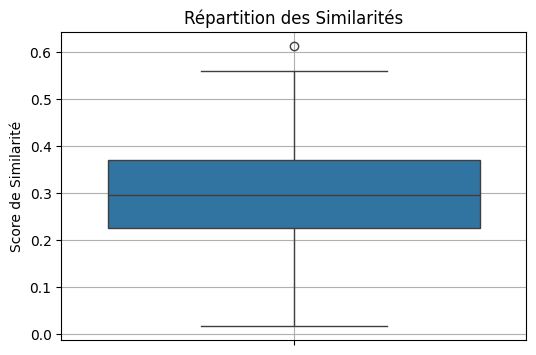

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

similarites = [item["similarity"] for item in keywordsVsMTD]

plt.figure(figsize=(6, 4))
sns.boxplot(y=similarites)
plt.title('Répartition des Similarités')
plt.ylabel('Score de Similarité')
plt.grid(True)
plt.show()


In [7]:
sum_similarities = 0 
for item in keywordsVsMTD :
    sum_similarities+=item['similarity']
    
sum_similarities/len(keywordsVsMTD)

0.30013680393722925

In [5]:
similarites = [item["similarity"] for item in keywordsVsMTD]

nombre_total = len(similarites)
nombre_sup_015 = sum(s > 0.15 for s in similarites)
pourcentage_sup_015 = (nombre_sup_015 / nombre_total) * 100

print(f"Nombre de vidéos avec similarité > 0.15 : {nombre_sup_015}")
print(f"Pourcentage : {pourcentage_sup_015:.2f}%")


Nombre de vidéos avec similarité > 0.15 : 1039
Pourcentage : 94.45%


In [28]:
llmEvaluation = openJson("../jsons/llmEvaluation.json")
len(llmEvaluation)

1100

In [33]:
videos_sous_015 = [item for item in keywordsVsMTD if item["similarity"] <= 0.15]
videos_sous_015 = sorted(videos_sous_015, key=lambda x: x["similarity"])

videos_sur_015 = [item for item in keywordsVsMTD if item["similarity"] > 0.15]
videos_sur_015 = sorted(videos_sur_015, key=lambda x: x["similarity"])

In [31]:
for v in videos_sous_015:
    for Eval in llmEvaluation:
        if Eval['id_video']==v['id_video'] and Eval['decision']=='oui':
            print(v)
            print(Eval)
            print("\n")

{'id_video': 'Yc24O1r7FfU', 'similarity': 0.01691398024559021}
{'id_video': 'Yc24O1r7FfU', 'decision': 'oui', 'justification': 'Le titre mentionne une méthode de fabrication de lessive à partir de cendre, ce qui est une technique permettant de subvenir à un besoin (laver son linge) de manière autonome.', 'score': 7}


{'id_video': 'iaUboIY9X4Q', 'similarity': 0.016999468207359314}
{'id_video': 'iaUboIY9X4Q', 'decision': 'oui', 'justification': "Le titre suggère une production agricole importante, ce qui est un élément clé de l'autosuffisance alimentaire. Bien qu'il manque une description et des tags, le titre est suffisamment pertinent pour indiquer un lien avec la thématique.", 'score': 6}


{'id_video': 'qePUdJIw0Z4', 'similarity': 0.04405586048960686}
{'id_video': 'qePUdJIw0Z4', 'decision': 'oui', 'justification': 'Le titre "Habitat Résilient" suggère une approche visant à créer un lieu de vie autonome et durable, ce qui est un aspect central de l\'autosuffisance. Bien que la descri

In [34]:
for v in videos_sur_015:
    for Eval in llmEvaluation:
        if Eval['id_video']==v['id_video'] and Eval['decision']=='non':
            print(v)
            print(Eval)
            print("\n")

{'id_video': 'CDBkv2Az8RY', 'similarity': 0.1502985656261444}
{'id_video': 'CDBkv2Az8RY', 'decision': 'non', 'justification': "La vidéo parle de l'autonomie des jeunes handicapés, ce qui est différent de l'autosuffisance (qui se concentre sur la capacité à subvenir à ses besoins fondamentaux par soi-même, notamment alimentaires).", 'score': 2}


{'id_video': '6LEvKg8qKao', 'similarity': 0.15943597257137299}
{'id_video': '6LEvKg8qKao', 'decision': 'non', 'justification': 'La vidéo traite du financement de l\'autonomie des retraités, un sujet lié à la politique et au financement de la dépendance, mais pas directement à l\'autosuffisance telle que définie (production de sa propre nourriture, réduction de la dépendance au système économique). Le terme "autonomie" est utilisé ici dans un sens différent.', 'score': 2}


{'id_video': 'BMuf64URw5E', 'similarity': 0.1608438789844513}
{'id_video': 'BMuf64URw5E', 'decision': 'non', 'justification': "La vidéo semble être une présentation d'une cam

In [32]:
videos_sous_015 = [item for item in keywordsVsMTD if item["similarity"] <= 0.15]
videos_sous_015 = sorted(videos_sous_015, key=lambda x: x["similarity"])

for item in videos_sous_015:
    print(f"ID vidéo: {item['id_video']} - Similarité: {item['similarity']:.4f}")
for item in keywordsVsMTD:
    if item["similarity"] <= 0.15:
        print(f"ID vidéo: {item['id_video']} - Similarité: {item['similarity']:.4f}")


ID vidéo: Yc24O1r7FfU - Similarité: 0.0169
ID vidéo: iaUboIY9X4Q - Similarité: 0.0170
ID vidéo: wL_7d-gH7ek - Similarité: 0.0231
ID vidéo: 7xPUcKSaU-k - Similarité: 0.0254
ID vidéo: qePUdJIw0Z4 - Similarité: 0.0441
ID vidéo: KYHEJVVgxg8 - Similarité: 0.0447
ID vidéo: lSoWicUMVlM - Similarité: 0.0483
ID vidéo: nNK2KRrjj1s - Similarité: 0.0626
ID vidéo: SrFPFZ14loQ - Similarité: 0.0628
ID vidéo: uIib2jT2r3w - Similarité: 0.0688
ID vidéo: SGslcr5UEwQ - Similarité: 0.0723
ID vidéo: p7P39qBv9J4 - Similarité: 0.0743
ID vidéo: 8SW7OsOWlRY - Similarité: 0.0766
ID vidéo: De1X6ThCx9k - Similarité: 0.0802
ID vidéo: ZYI5bSJK1tU - Similarité: 0.0840
ID vidéo: 7pNeqTZuT7E - Similarité: 0.0862
ID vidéo: e-UlGJIa6RI - Similarité: 0.0904
ID vidéo: jhs5BvrlT88 - Similarité: 0.1013
ID vidéo: 7JIDkOO9PP0 - Similarité: 0.1028
ID vidéo: 2grH3e2-LxA - Similarité: 0.1060
ID vidéo: iDIIKfmqNZ8 - Similarité: 0.1102
ID vidéo: Npz3P9yABz8 - Similarité: 0.1103
ID vidéo: CpCFEaqU47E - Similarité: 0.1122
ID vidéo: y

In [25]:
contexte_autosuffisance = [
    "Potager familial productif pour l'autonomie en légumes",
    "Élevage de poules, moutons et canards pour l’autonomie alimentaire",
    "Utilisation de plantes médicinales et aromatiques cultivées sur place",
    "Récupération et filtration de l'eau via un puits et osmose inverse",
    "Construction de bacs permacoles faits maison pour une culture efficace",
    "Transformation du sol en terre fertile pour maximiser les rendements",
    "Vie en sobriété heureuse et respect de la nature",
    "Utilisation de semences locales et choix variétal réfléchi",
    "Production locale de viande, œufs et légumes",
    "Utilisation d'une serre pour prolonger les cultures",
    "Métiers artisanaux (ébénisterie, photographie culinaire) intégrés dans le mode de vie",
    "Conception d’un lieu de vie en autonomie énergétique et alimentaire"
]


In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
scores = {}
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,documents)
    print(score,'  ',video['id_video'])
    scores[video['id_video']]=score


In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
scores = {}
for video in tqdm(videosF2):
    context = video['titre_video'] + video['description'] + ' '.join(video['tags'])
    score = calculateSimilarity(context,contexte_autosuffisance)
    print(score,'  ',video['id_video'])
    scores[video['id_video']]=score


### LLM Scoring

In [3]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [4]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"))
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"))

In [5]:
sysprompt = """
# La definition d'autossuffinnce

L'autosuffisance est la démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux, 
en premier lieu alimentaires par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture, 
souvent en privilégiant le bio, le local et le saisonnier. 

L'autosuffisance Plus qu'une simple recherche d'autonomie matérielle, elle représente un engagement pour être moins dépendant du système économique et social extérieur, impliquant des choix concrets comme trouver un lieu propice et le concevoir judicieusement (par exemple en permaculture), 
ainsi qu'un changement dans la manière de valoriser son temps et de consommer, formant ainsi le fondement d'une vie plus autonome.

---

# Votre mission

- Décider si une vidéo concerne la thématique de l'autosuffisance en se basant sur ses métadonnées (titre, description, tags).  
- Les vlogs, les interviews et les vidéos de partage d'expériences en lien avec l'autosuffisance sont intéressants.  
- Les tutoriels et les vidéos de conseils sont également pertinents.  
- Les vidéos présentant une technique liée à l'autosuffisance ou y contribuant sont utiles.  
- Attribuer un score entier de 1 à 10 pour évaluer la pertinence de la vidéo par rapport à la thématique de l'autosuffisance.

---

# Votre réponse  

- La réponse doit être au format JSON :  
  
    "decision": "oui ou non",
    "justification": "Justifiez votre décision avec des arguments"
    "score": votre èvaluation
 
"""

userprompt = """
Titre
---
{titre}
Description
---
{description}
tags
---
{tags}
"""

prompt = ChatPromptTemplate([
    ("system", sysprompt),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2


- Test

In [6]:
input = {"titre":"Tuteurer et redresser un arbre 🌳",
         "description":"Dans cette vidéo nous allons voir ensemble comment mettre un tuteur afin de redresser un arbre qui penche suite à la tempête.\nCette vidéo vous aideras pour placer un tuteur en travers , sangler un arbre selon le sens du vent,\n\nIl existe plusieurs facon de tuteurer un arbre, haubanage, tripode,.. mais dans le cas présent un tuteur en biais suffiras puisque l'arbre n'est pas trés gros.\n\n\n▬▬▬▬▬▬▬▬▬▬▬ POUR ALLER PLUS LOIN  ▬▬▬▬▬▬▬▬▬▬▬\n\n💡 Abonnez-vous pour me soutenir 🧡\n\n\n💡Rejoignez-nous sur twitter\net tik tok\n\n\n▬▬▬▬▬▬▬▬▬▬▬ CHAPITRES DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬\n\n00:00 : Introduction\n00:23 : Mise en place tuteur\n01:54 : Sanglage et Redresser l'arbre\n02:54 : Sens du vent et détails tuteurage\n\n▬▬▬▬▬▬▬▬▬▬▬ A PROPOS DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬▬\n\nLe Jardin du moulin\nFrancois\n#potager #jardindumoulin",
         "tags":', '.join( [
      "TCS",
      "Agriculture Biologique",
      "Bio",
      "GAB 85",
      "FNAB",
      "Vendée",
      "Techniques Culturales Simplifiées",
      "GAEC Les Jonquilles",
      "ECOPHYTO",
      "Demain Vendée",
      "Conservation des sols",
      "Sol vivant",
      "Productions végétales",
      "Maïs"
    ])}
print(input)
print(chain_2.invoke(input))

{'titre': 'Tuteurer et redresser un arbre 🌳', 'description': "Dans cette vidéo nous allons voir ensemble comment mettre un tuteur afin de redresser un arbre qui penche suite à la tempête.\nCette vidéo vous aideras pour placer un tuteur en travers , sangler un arbre selon le sens du vent,\n\nIl existe plusieurs facon de tuteurer un arbre, haubanage, tripode,.. mais dans le cas présent un tuteur en biais suffiras puisque l'arbre n'est pas trés gros.\n\n\n▬▬▬▬▬▬▬▬▬▬▬ POUR ALLER PLUS LOIN  ▬▬▬▬▬▬▬▬▬▬▬\n\n💡 Abonnez-vous pour me soutenir 🧡\n\n\n💡Rejoignez-nous sur twitter\net tik tok\n\n\n▬▬▬▬▬▬▬▬▬▬▬ CHAPITRES DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬\n\n00:00 : Introduction\n00:23 : Mise en place tuteur\n01:54 : Sanglage et Redresser l'arbre\n02:54 : Sens du vent et détails tuteurage\n\n▬▬▬▬▬▬▬▬▬▬▬ A PROPOS DE CETTE VIDÉO ▬▬▬▬▬▬▬▬▬▬▬\n\nLe Jardin du moulin\nFrancois\n#potager #jardindumoulin", 'tags': 'TCS, Agriculture Biologique, Bio, GAB 85, FNAB, Vendée, Techniques Culturales Simplifiées, GAEC Les Jonqu

In [ ]:
def cleanAnswer(answer):
    answer = answer.strip("`")   # Supprimer tous les backticks
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [ ]:
videosF2 = openJson("../jsons/videosF2.json")
llmEvaluation = []
count1 = 0
count2 = 0
temp = 0

for video in tqdm(videosF2):
    input = {"titre":video['titre_video'],
             "description":video['description'],
             "tags":', '.join(video['tags']),}
    try:
        if count1  <= 13:
            print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            #print(video['id_video'],'/n',answer)
            evaluation = {}
            evaluation['id_video']=video['id_video']
            evaluation.update(json.loads(answer))
            llmEvaluation.append(evaluation)
            
            count1+=1
            temp+=1            
             
            print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            print("KEY 2")
            
            answer =  cleanAnswer(chain_2.invoke(input))
            #print(video['id_video'],'/n',answer)
            evaluation = {}
            evaluation['id_video']=video['id_video']
            evaluation.update(json.loads(answer))
            llmEvaluation.append(evaluation)
            
            count2+=1
            temp+=1
            print("count2 ",count2)  
            
        if count1 > 13 and count2 > 13 :
            print("sleep for 1 min")
            time.sleep(60)
            count1 = 0
            count2 = 0
        

        if temp >= 100:
            saveJson("../jsons/llmEvaluation.json",llmEvaluation)
            temp=0
            
    except Exception as e:
        print(f"error {e}")

- Seperate the videos classified as not relevent

In [9]:
llmEvaluations = openJson("../jsons/llmEvaluation.json")
videosF2 = openJson("../jsons/videosF2.json")

def getNonVideo(ID):
    for video in videosF2:
        if video['id_video']==ID:
            return video

In [4]:
len(videosF2)

4504

In [10]:
len(llmEvaluations)

1100

In [ ]:
videosNon = []
for evaluation in llmEvaluations:
    try:

        if evaluation['decision'] =='non':
            videoNo = getNonVideo(evaluation['id_video'])
            videoNo.update(evaluation)
            videosNon.append(videoNo)
    except:
        print(evaluation)
        break
    
saveJson("../jsons/llmVideosNon.json",videosNon)

In [ ]:
len(videosNon)

In [11]:
videosNon = openJson("../jsons/llmVideosNon.json")
len(videosNon)

45

In [13]:
(45/1100)*100

4.090909090909091

In [15]:
scorellm = []
for v in videosNon:
    scorellm.append(v['score'])

In [20]:
max(scorellm)

3

In [21]:
import pandas as pd

data = []
for video in videosNon:
    data.append({
        "lien_video": f"https://www.youtube.com/watch?v={video['id_video']}",
        "titre": video["titre_video"],
        "decision": video["decision"],
        "justification": video["justification"],
        "score": video["score"]
    })

df = pd.DataFrame(data)
df.to_excel("../jsons/videosNon.xlsx", index=False)


- Number of search queries

In [13]:
channelsR1 = openJson("../jsons/channelsR1.json")

In [25]:
queriesCounter = []
for video in videosF2:
    for channel in channelsR1:
        if channel['id_chaine'] == video['id_chaine']:
            channelname = channel['nom_chaine']
    queriesCounter.append({
        'id_video': video['id_video'],
        'numQueries': len(video['requete']),
        'channelname': channelname
    })

queriesCounter = sorted(queriesCounter, key=lambda x: x['numQueries'], reverse=True)

total_queries = sum(item['numQueries'] for item in queriesCounter)
nombre_videos = len(queriesCounter)
moyenne_queries = total_queries / nombre_videos

print(queriesCounter[:5])
print(moyenne_queries)

[{'id_video': 'iF3O2TSheXI', 'numQueries': 162, 'channelname': "L'ArchiPelle"}, {'id_video': 'B21So1_VYMY', 'numQueries': 112, 'channelname': "L'ArchiPelle"}, {'id_video': '6CI-4_XszYg', 'numQueries': 107, 'channelname': "Le Jardin d'Emerveille"}, {'id_video': 'POPtzy-5jLg', 'numQueries': 97, 'channelname': "L'ArchiPelle"}, {'id_video': 'FZBgBkMdgTg', 'numQueries': 88, 'channelname': 'Comme un pingouin dans le désert (autoconstruction bois)'}]
2.861234458259325


In [35]:
queriesCounterNon = []
for video in videosNon:
    for channel in channelsR1:
        if channel['id_chaine']==video['id_chaine']:
            channelname = channel['nom_chaine']
    queriesCounterNon.append(
        {
            'id_video':video['id_video'],
            'numQueries':len(video['requete']),
            'channelname':channelname
        }
    )

queriesCounterNon = sorted(queriesCounterNon, key=lambda x: x['numQueries'], reverse=True)

videos_less_than_2_queries = [video for video in queriesCounterNon if video['numQueries'] <= 2]
percentage = (len(videos_less_than_2_queries) / len(queriesCounterNon)) * 100
print(f"Pourcentage de vidéos (Parmi les 45 non-pertinents) avec <= 2 requêtes : {percentage:.2f}%")


Pourcentage de vidéos (Parmi les 45 non-pertinents) avec <= 2 requêtes : 86.67%


### Indice de pertinence

I.P = llmScore × α + numQueries × β

- On teste au depart avec alpha= 0.7 et beta = 0.3

In [6]:
llmEvaluations = openJson("../jsons/llmEvaluation.json")
videosF2 = openJson("../jsons/videosF2.json")

def getnbrQueries(ID):
    for video in videosF2:
        if video['id_video']==ID:
            return len(video['requete'])

In [8]:
def calculateIP(alpha,beta):
    echantillonIP = []

    for eval in llmEvaluations:
        nbrQueries = getnbrQueries(eval['id_video'])
        llmScore = eval['score']
        ip = llmScore*alpha + nbrQueries*beta
        echantillonIP.append(
            {
                'id_video':eval['id_video'],
                'llmScore':eval['score'],
                'nbrQueries':nbrQueries,
                'IP':ip
            }
        )
    return echantillonIP    

In [9]:
echantillonIP = calculateIP(0.7,0.3)
saveJson("../jsons/echantillonIP.json",echantillonIP)


 json saved


In [34]:
len(echantillonIP)

1100

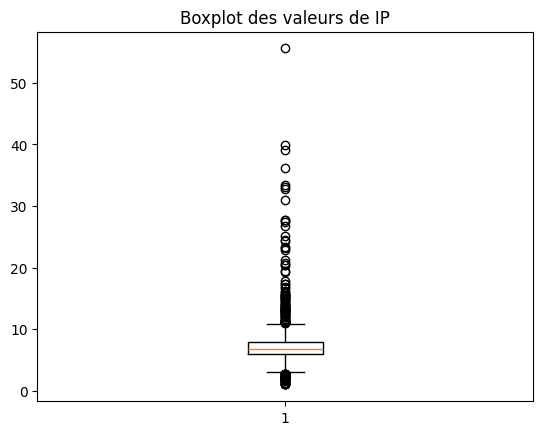

Min     = 1.00
Q1      = 5.90
Median  = 6.80
Q3      = 7.90
Max     = 55.60
IQR     = 2.00
Limite inférieure des moustaches = 2.90
Limite supérieure des moustaches = 10.90


In [38]:
import numpy as np

ip_values = [item['IP'] for item in echantillonIP]

plt.boxplot(ip_values, vert=True)
plt.title('Boxplot des valeurs de IP')
plt.show()

min_val = np.min(ip_values)
q1 = np.percentile(ip_values, 25)
median = np.median(ip_values)
q3 = np.percentile(ip_values, 75)
max_val = np.max(ip_values)

iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f'Min     = {min_val:.2f}')
print(f'Q1      = {q1:.2f}')
print(f'Median  = {median:.2f}')
print(f'Q3      = {q3:.2f}')
print(f'Max     = {max_val:.2f}')
print(f'IQR     = {iqr:.2f}')
print(f'Limite inférieure des moustaches = {lower_limit:.2f}')
print(f'Limite supérieure des moustaches = {upper_limit:.2f}')


In [43]:
filtredVidoesIP = []
for ech in echantillonIP:
    if ech['IP'] < 2.9:
        filtredVidoesIP.append(ech)
    
saveJson("../jsons/filtredVidoesIP.json",filtredVidoesIP)


 json saved


In [41]:
len(filtredVidoesIP)

50